# Ihsan Gunay Project 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm
%matplotlib inline

## Likelihoods, Weight Priors & Data Space

In [12]:
N = 100                            
beta = 25                
alpha = 2.0    
a0 = -0.3                          
a1 = 0.5  

mu_0 = [0, 0]
cov_0 = (1/alpha) * np.identity(2)

x = np.random.uniform(-1, 1, N)
noise = np.random.normal(0, 0.2, N) 
y = a0 + (a1 * x) + noise

mu = mu_0
s = cov_0

plot_vals = [0, 1, 2, 4, 25]
w0, w1 = np.mgrid[-1:1:.01, -1:1:.01]
span = np.dstack((w0, w1))

prior = multivariate_normal(mu, s)
fig = plt.figure(figsize=(120,60))
ax1 = fig.add_subplot(632)
ax1.set_xlabel('w0')
ax1.set_ylabel('w1')
ax1.set_title('Contour plot of Initial Weight Estimates')
ax1.contourf(w0, w1, prior.pdf(span))
ax1.set_aspect('equal')
plt.tight_layout()

w_s = np.random.multivariate_normal(mu, s, 10) #samples
x_s = np.linspace(-1, 1, N)
y_s = np.zeros((10, 100))
for i in range(10):
    y_s[i] = w_s[i, 0] + x_s * w_s[i, 1]

ax2 = fig.add_subplot(633)
ax2.set_xlabel('w0')
ax2.set_ylabel('w1')
ax2.set_title('Initial Data Space')
ax2.set_aspect('equal')
for m in range(y_s.shape[0]):
    ax2.plot(x_s, y_s[m,:])


basis = np.array([[1 , x[0]]])  #basis functions 1 and x
for i in range(N):
    if not i == 0:
        basis = np.concatenate((basis, np.array([[1, x[i]]])), axis=0)     
    basisT = basis.T
    s_inv = alpha * np.identity(2) + beta * basisT.dot(basis)
    s = np.linalg.inv(s_inv)
    mu = beta * s.dot(basisT).dot(y[0:i+1].T)
    
    if i in plot_vals:
        #plot likelihood
        ax3 = fig.add_subplot(6,3,4 + plot_vals.index(i) * 3)
        x1 = np.linspace(-1, 1, 101)
        y1 = np.linspace(-1, 1, 101)
        surface = np.zeros((len(x1), len(x1)))
        for j in range(101):            
            w_0 = x1[j]    
            for k in range(101): 
                w_1 = y1[k]
                mu_up = w_0 + (w_1*x1[i])
                surface[j, k] = norm(mu_up, 1/beta).pdf(y[i-1])
        ax3.set_xlabel('w0')
        ax3.set_ylabel('w1')
        ax3.set_title('Heat map of likelihood for observation ' + str(i + 1))
        ax3.imshow(surface, cmap='afmhot', interpolation='nearest', extent=[-1,1,-1,1])
        ax3.set_aspect('equal')
        
        #plot prior
        prior = multivariate_normal(mu, s)
        ax4 = fig.add_subplot(6,3,5 + plot_vals.index(i) * 3)
        ax4.set_xlabel('w0')
        ax4.set_ylabel('w1')
        ax4.set_title('Contour plot of weight estimates at observation ' + str(i + 1))
        ax4.contourf(w0, w1, prior.pdf(span))
        ax4.set_aspect('equal')
        
        #plot data space 
        w_s = np.random.multivariate_normal(mu, s, 10)
        y_s = np.zeros((10, 100))
        for j in range(10):
            y_s[j] = w_s[j, 0] + x_s * w_s[j, 1]
        
        ax5 = fig.add_subplot(6,3,6 + plot_vals.index(i) * 3)
        ax5.set_xlabel('w0')
        ax5.set_ylabel('w1')
        ax5.set_title('Data space at observation ' + str(i + 1))
        for j in range(y_s.shape[0]):
            ax5.plot(x_s, y_s[j,:])
            ax5.set_aspect('equal')

## Variation Over Data & Training

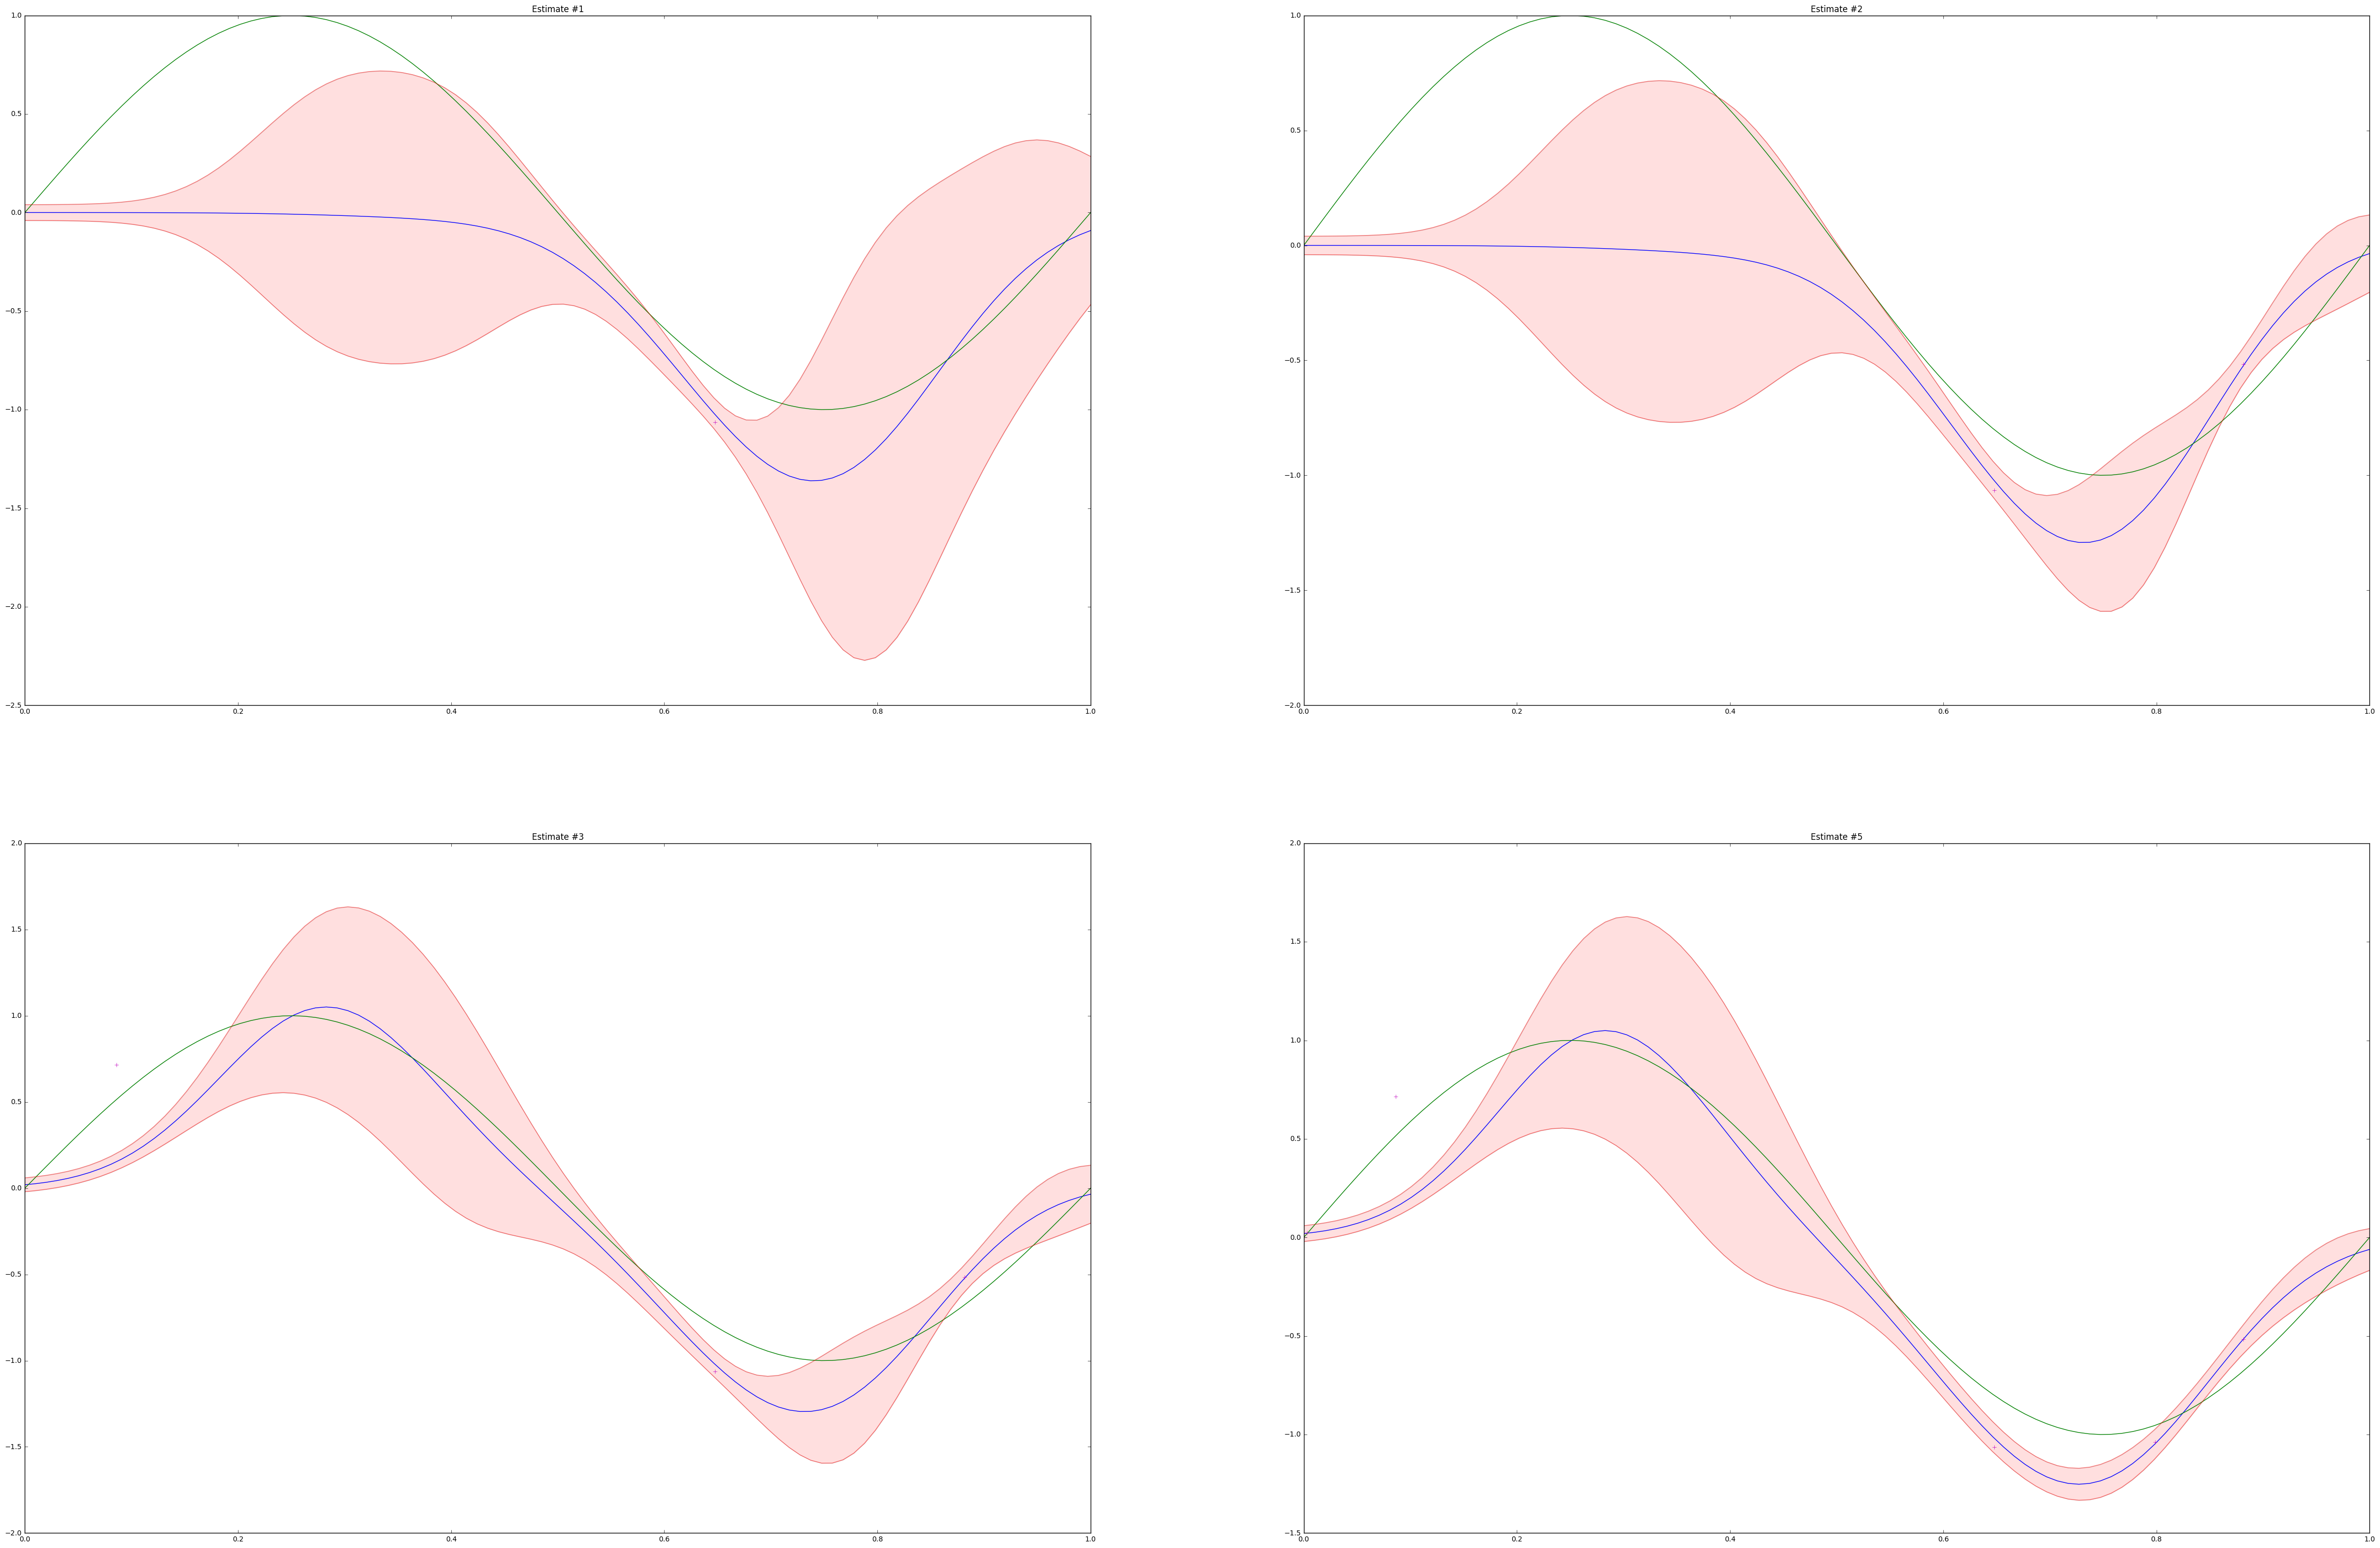

In [15]:
N = [0, 1, 2, 4, 25]
beta = 25
alpha = 2.0                     

#generate data
x0 = np.linspace(0, 1, 100)
y0 = np.sin(2 * np.pi * x0)

x = np.random.uniform(0, 1, N[-1] + 1)
noise = np.random.normal(0, 0.15, N[-1] + 1)
y = np.sin(2 * np.pi * x) + noise

fig = plt.figure(figsize=(60,60))
mu = np.random.uniform(0, 1, 9)  
s = 0.1                         

k = 1
x_sample = np.ones(9) * x[0]
basis = np.array([np.exp(-np.multiply(x_sample - mu, x_sample - mu)/(2*s*s))]) 
for i in range(N[-1]):
    x_sample = np.ones(9) * x[i]
    basis2 = np.array([np.exp(-np.multiply(x_sample - mu, x_sample - mu)/(2*s*s))])
    if not i == 0:
        basis = np.concatenate((basis, basis2), axis=0)     
    basisT = basis.T
    s_inv = (alpha * np.identity(9)) + (beta * basisT.dot(basis))
    SN = np.linalg.inv(s_inv)
    y_N = y[0:i+1].T
    mN = beta * SN.dot(basisT).dot(y_N)
    
    #plot estimate
    muN = np.zeros(100)
    SN_x = np.zeros(100)
    for j in range(len(x0)):
        x_sample = np.ones(9) * x0[j]
        phi = np.array([np.exp(-np.multiply(x_sample - mu, x_sample - mu)/(2*s*s))])
        muN[j] = np.dot(mN.T.flatten(), phi.flatten())
        SN_x[j] = (1/beta) + np.dot(np.dot(phi, SN), phi.T)
    if i in N:
        ax2 = fig.add_subplot(320 + k)
        ax2.set_title('Estimate #' + str(i+1))
        ax2.plot(x0, muN)
        ax2.plot(x0, y0, 'g')
        ax2.plot(x[0:i+1], y[0:i+1], 'm+')
        ax2.fill_between(x0, muN + SN_x, muN - SN_x, facecolor='red', alpha=.125)
        ax2.plot(x0, muN + SN_x, 'r', alpha=.5)
        ax2.plot(x0, muN - SN_x, 'r', alpha=.5)
        k += 1